In [26]:
!jupyter nbconvert --to html "Filtro_FIR.ipynb"

[NbConvertApp] Converting notebook Filtro_FIR.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 1728091 bytes to Filtro_FIR.html


# Análise de Cargas com Filtros FIR e IIR

Este trabalho foi desenvolvido pelos estudantes do curso de Engenharia de Computação da UFC Quixada, Guilherme Araújo Floriano, Eliton Pereira Melo e Ryan Guilherme Moraes Nascimento. 

Seu objetivo é aplicar os conceitos de projeto de filtros digitais (FIR e IIR) para analisar, identificar e caracterizar o consumo de cargas elétricas domésticas (NILM – Non-Intrusive Load Monitoring)

## Filtro FIR

### 1 - Introdução ao Problema NILM

NILM (Non-Intrusive Load Monitoring, ou Monitoramento de Carga Não Intrusivo) é uma técnica para analisar a energia elétrica total consumida por uma residência e decompor esse consumo nos aparelhos individuais que a compõem.  O "não intrusivo" significa que isso é feito usando apenas um único medidor principal, sem a necessidade de instalar sensores em cada aparelho.

Relevância: A importância do NILM reside em sua capacidade de:

- Fornecer feedback detalhado sobre o consumo de energia: Permite que os moradores entendam quais aparelhos consomem mais, incentivando a economia de energia.
- Detecção de falhas e manutenção preditiva: Mudanças no padrão de consumo de um aparelho podem indicar um defeito iminente.

- Aplicações para concessionárias de energia: Ajuda a entender melhor os padrões de demanda da rede elétrica.

### 2 - Escolha e Exploração do Banco de Dados

Para o presente trabalho, será utilizado o database UK-dale, que é muito completo, com dados de baixa e alta frequência (16 kHz para
corrente/tensão do medidor principal, ideal para análise de transientes e
harmônicas).

Acesso: https://jack-kelly.com/data/ ou https://ukdale.com/

Além disso, como descrito no artigo e nos documentos, ele possuis estruturas YAML no padrão esperado pela biblioteca [nilmtk](https://github.com/nilmtk/nilmtk), uma biblioteca em python que facilita análise dos dados medidos por instrumentos NILM.

Como descrito na documentação do projeto, será criada um ambiente virtual do python para instalação correta da biblioteca e de seus requisitos.

In [1]:
!sudo apt install python3.11-venv
!python3 -m venv nilm-env
!source nilm-env/bin/activate

%pip install git+https://github.com/nilmtk/nilmtk.git

[sudo] password for guilherme: 
sudo: a password is required
^C
  Cloning https://github.com/nilmtk/nilmtk.git to /tmp/pip-req-build-0jux2jy6
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk.git /tmp/pip-req-build-0jux2jy6
  Resolved https://github.com/nilmtk/nilmtk.git to commit e5c3c1ae02cc9f1d2ec4c3d7ea576fb26190dfa9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/nilmtk/nilm_metadata.git to /tmp/pip-install-jku_ov3z/nilm-metadata_a385b1f100b449b2a0234ddf579346a0
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilm_metadata.git /tmp/pip-install-jku_ov3z/nilm-metadata_a385b1f100b449b2a0234ddf579346a0
ERROR: Operation cancelled by user
^C
Note: you may need to restart the kernel to use updated packages.


#### Criando h5

O dataset UK-DALE original é composto por múltiplos arquivos de texto (.dat) para cada residência. Para otimizar o acesso e a manipulação, esses dados foram previamente convertidos para um único arquivo no formato HDF5 (.h5). Este é um formato de arquivo binário projetado para armazenar e organizar grandes quantidades de dados numéricos, permitindo um acesso muito mais rápido do que a leitura de múltiplos arquivos de texto.

Note que é um processo demorado pelo tamanho da database (16 gb), de forma que é interessante manter o h5 gerado a fim de evitar essa execução constantemente.

In [ ]:
from nilmtk.dataset_converters import convert_ukdale

ukdale_path = 'ukdale/'

hdf_output_file = 'uk-dale.h5'

print(f"Iniciando a conversão de {ukdale_path} para {hdf_output_file}...")
convert_ukdale(ukdale_path, hdf_output_file)
print("Conversão concluída!")

Iniciando a conversão de /content/drive/MyDrive/UFC/7° Semestre/ProcessamentoDigital/ukdale/ para uk-dale.h5...


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 836, in H5Fopen
    unable to synchronously open file
  File "H5F.c", line 796, in H5F__open_api_common
    unable to open file
  File "H5VLcallback.c", line 3863, in H5VL_file_open
    open failed
  File "H5VLcallback.c", line 3675, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 128, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 2018, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 600, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/content/drive/MyDrive/UFC/7° Semestre/ProcessamentoDigital/ukdale/metadata/ukdale_metadata.h5'

#### Importando dataset

O código na célula a seguir realiza as etapas fundamentais de inicialização e extração dos dados necessários para a análise.

#### Detalhamento dos Passos:
  * **`dataset = DataSet('uk-dale.h5')`**: Cria uma instância do objeto `DataSet`, carregando os metadados e preparando o acesso ao arquivo `uk-dale.h5`.
  * **`elec = dataset.buildings[building_num].elec`**: Acessamos a residência desejada (`buildings[1]` para a Casa 1) e, em seguida, seu atributo `.elec`. Isso nos retorna um objeto do tipo **`MeterGroup`**, que é uma coleção poderosa contendo todos os medidores elétricos (`ElecMeter`) daquela casa.
  * **`dataset.set_window(...)`**: Aplica um filtro temporal em todo o `dataset`. [cite\_start]Qualquer extração de dados subsequente retornará apenas os dados contidos neste intervalo, o que é essencial para realizar uma análise focada. [cite: 114]
  * **`elec.mains()`**: É um método de conveniência do `MeterGroup` que retorna o objeto `ElecMeter` correspondente ao medidor principal (`site_meter`).
  * **`.power_series_all_data()`**: Este método é chamado no objeto do medidor principal para carregar a série temporal de potência (em Watts) dentro da janela de tempo previamente definida. O resultado é um objeto `Series` da biblioteca Pandas.
  * **`.dropna()`**: Um passo de limpeza de dados fundamental que remove quaisquer valores ausentes (`NaN`) da série temporal. Isso evita erros em cálculos matemáticos e de filtragem nas etapas seguintes.

O resultado final desta célula é a variável `mains_power`, uma série temporal do Pandas contendo o consumo de energia agregado da residência, pronta para ser processada pelos filtros FIR na próxima etapa.

In [13]:
# --- Imports e Configurações Iniciais ---
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import firwin, filtfilt
import numpy as np
from nilmtk import DataSet

# Configurações do matplotlib para os gráficos
plt.rcParams['figure.figsize'] = [15, 8]

# --- Carregamento do Dataset ---
print("Carregando o dataset HDF5...")
dataset = DataSet('../uk-dale.h5')

# Escolha a casa e o período para análise
building_num = 2

# dataset.set_window(start="2013-05-26", end="2013-05-27") # Tempo para casa 1
dataset.set_window(start="2013-04-25", end="2013-04-30") # Tempo para casa 2
# dataset.set_window(start="2013-02-27", end="2013-03-10") # Tempo para casa 3
#dataset.set_window(start="2013-03-09", end="2013-03-15") # Tempo para casa 4
#dataset.set_window(start="2014-06-29", end="2014-07-03") # Tempo para casa 5

elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

print(f"Dados da Casa {building_num} carregados com sucesso.")
print(f"Período selecionado: de {mains_power.index[0]} a {mains_power.index[-1]}")

Carregando o dataset HDF5...
Dados da Casa 2 carregados com sucesso.
Período selecionado: de 2013-04-25 00:00:00.599999905+01:00 a 2013-04-29 23:59:58.900000095+01:00


#### Gráfico geral do dataset

Tendo o dataset em posse, podemos gerar os mais variados gŕaficos. Abaixo estão apresentados os gráficos de consumo específico de cada dispositivo, consumo agregado e consumo particular de um dispositivo escolhido.

Note que essas informações acontecem em datas diferentes, mas como são muito dados, os gráficos foram separados por casa e janelas de tempo específica para exemplo foram disponibilizadas para um teste mais facilitado.

In [ ]:
elec.plot()
plt.title(f'Consumo de Eletricidade - Casa {building_num}')
plt.xlabel('Tempo')
plt.ylabel('Potência Ativa (Watts)')
plt.show()

NameError: name 'elec' is not defined

#### Gráfico agregado e de um dispositivo particular

Além disso, o NILMTK também nos permite extrair informações específicas do arquivo h5, podendo pegar dados de um determinado canal e até mesmo identificados valores de consumo agregado, que geralmente são definidos como um medidor principal main.

No entanto, alguns YAML (como o da casa 2), não possuem um medidor central difinido, ou possuem mais de um, dessa forma, temos que fazer uma manipulação para encontrar manualmente o mains da casa.

Abaixo está o gráfico do consumo agregado definido como acima.

Medidor principal ('site_meter') encontrado manualmente: ElecMeter(instance=20, building=2, dataset='UK-DALE', site_meter, appliances=[])
Plotando os dados do medidor principal...


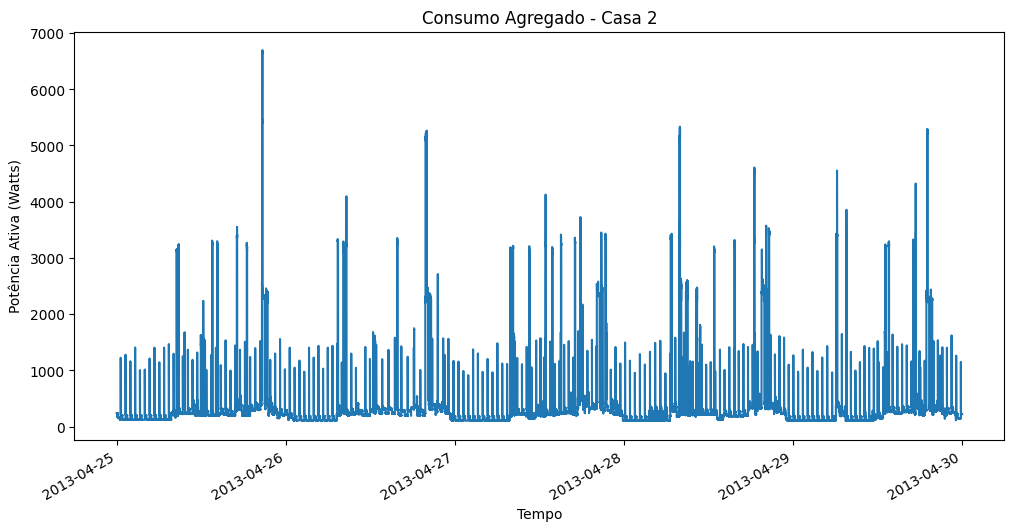

In [ ]:
mains_meter = None
for meter in elec.meters:
    if meter.is_site_meter():
        print(f"Medidor principal ('site_meter') encontrado manualmente: {meter}")
        mains_meter = meter
        break

if mains_meter:
    print("Plotando os dados do medidor principal...")
    aggregated_data = mains_meter.power_series_all_data()

    if aggregated_data is not None and not aggregated_data.empty:
        aggregated_data.plot(figsize=(12, 6))
        plt.title(f'Consumo Agregado - Casa {building_num}')
        plt.ylabel('Potência Ativa (Watts)')
        plt.xlabel('Tempo')
        plt.show()
    else:
        print(f"Os dados para o medidor principal da Casa {building_num} estão vazios ou não puderam ser carregados.")
else:
    print(f"ERRO CRÍTICO: Não foi possível encontrar o medidor principal para a Casa {building_num}.")

Além disso, podemos gerar gráficos de dispositivos escolhidos.

Aqui, a biblioteca armazena na base de dados central informações sobre os nomes dos dispositivos presente no YAML e no labals.dat, de forma que podemos filtrar os dados pelo nome do dispositivo e obter a base de dados do seu canal.

Dessa forma, o gráfico abaixo foi gerado para identificar melhor como funciona a forma de onda no tempo dos aparelhos.

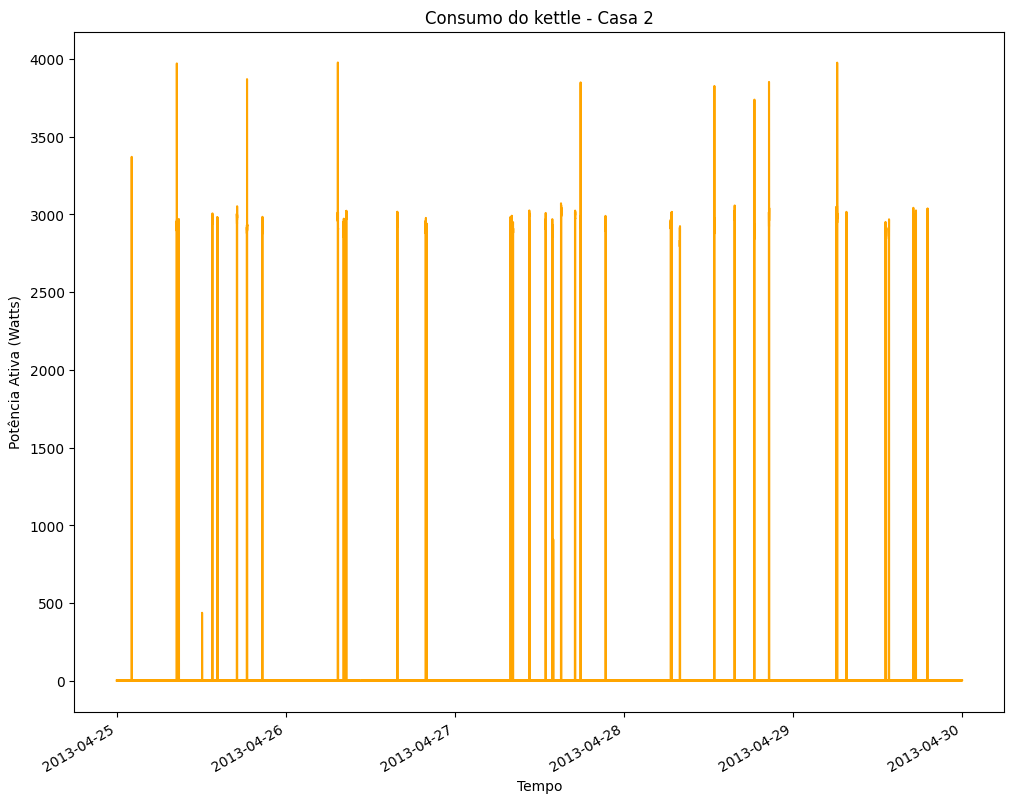

In [ ]:
# --- Plotando o consumo de um aparelho específico (ex: geladeira) ---
# O nome do aparelho deve corresponder ao que está no 'labels.dat'
try:
    device_name = 'kettle'  # Altere para o nome do aparelho que você quer analisar
    device_data = elec[device_name].power_series_all_data()
    device_data.plot(figsize=(12, 10), color='orange')
    plt.title(f'Consumo do {device_name} - Casa {building_num}')
    plt.ylabel('Potência Ativa (Watts)')
    plt.xlabel('Tempo')
    plt.show()
except KeyError:
    print(f"Aparelho {device_name} não encontrado na casa {building_num}. Verifique o 'labels.dat' da casa.")

### 3 - Detecção de Eventos (Transientes ON/OFF) com Filtros FIR

#### Visualizando a FFT do sinal de um dispositivo
Agora que consigimos observar os gráficos, podemos verificar algo interessante. Os eventos de transientes são eventos de degrau no tempo, de modo que ao observar no domínio da frequência, sendo que a frequência de amostragem é 1/6 Hz, já que as amostras são obtidas a cada 6 segundos, temos que:


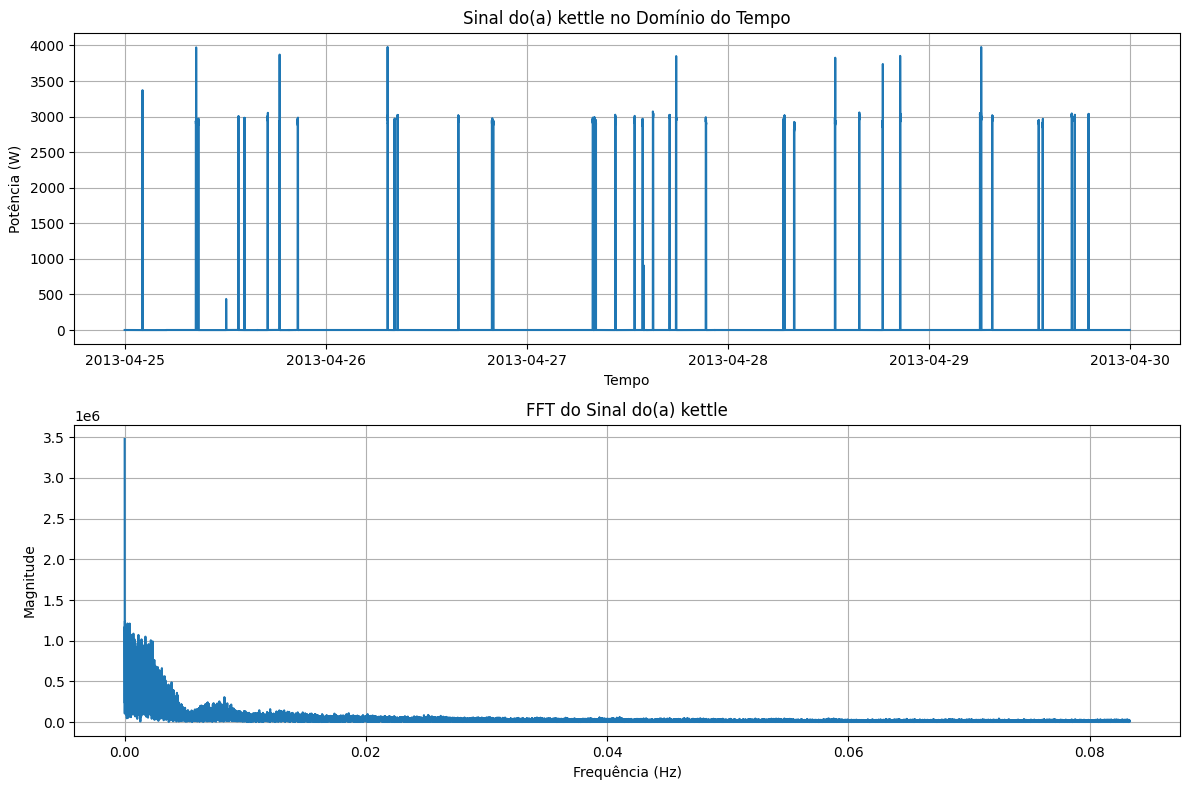

In [ ]:
# Carregar dados
device_name = 'kettle'
device_power = elec[device_name].power_series_all_data().dropna()

# Calcular a FFT
fs = 1/6.0
fft_device = np.fft.rfft(device_power)
fft_freqs = np.fft.rfftfreq(len(device_power), d=1.0/fs)
fft_magnitude = np.abs(fft_device)

# Plotar os sinais
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Sinal no domínio do tempo
axes[0].plot(device_power)
axes[0].set_title(f'Sinal do(a) {device_name} no Domínio do Tempo')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Potência (W)')
axes[0].grid()

# Sinal no domínio da frequência (FFT)
axes[1].plot(fft_freqs, fft_magnitude)
axes[1].set_title(f'FFT do Sinal do(a) {device_name}')
axes[1].set_xlabel('Frequência (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].grid()

plt.tight_layout()
plt.show()

Ou seja, esse sinal é composto por uma componente DC de alta magnitude e o degrau se espalha nas componentes de alta frequência.

Dessa forma, o sinal agregado (mains) tem um problema: a componente DC (o consumo de base de todos os aparelhos que já estão ligados) é muito grande em comparação com a mudança que queremos detectar.

Assim, o filtro passa-altas é uma ferramenta adequada e suficiente para eliminar essas componentes e nos permitir detectar os transientes.

Ao projetar um filtro passa-altas com uma frequência de corte muito baixa (e.g., 0.005 Hz), estamos dizendo ao sistema: "Ignore completamente qualquer nível de potência que seja constante ou mude muito devagar (a componente DC e de baixíssima frequência). Mostre-me APENAS as mudanças rápidas e abruptas."

Cortamos a componente DC precisamente porque ela representa o ESTADO, e nosso objetivo é detectar o EVENTO. Ao remover a informação do estado, o que sobra são apenas os eventos, que aparecem como picos claros e fáceis de detectar com um limiar.


#### Características
Todo projeto de filtro começa com uma especificação "ideal". Para o nosso filtro passa-altas, a resposta em frequência ideal seria uma "parede de tijolos" (brick wall):
 * Ganho 0 para todas as frequências na banda de rejeição (de 0 Hz até a frequência de corte fc).
 * Ganho 1 para todas as frequências na banda de passagem (de fc até a frequência de Nyquist).

Para transformar essa resposta em frequência ideal em um filtro FIR (ou seja, encontrar seus coeficientes), precisaríamos calcular a Transformada de Fourier Inversa. O problema é que a transformada inversa de uma "parede de tijolos" ideal é uma função sinc ($\frac{sin(x)}{x}$) no domínio do tempo.

A função $sinc(x)$ é infinita em duração. Para criar um filtro Finito, nós somos forçados a truncar ou cortar essa resposta infinita em algum ponto.

Dessa forma, o janelamento de Hamming foi escolhido porque:

* Sua atenuação de -41 dB é mais do que suficiente para suprimir fortemente a componente DC e o ruído de baixa frequência, garantindo que a saída do nosso filtro seja muito próxima de zero, exceto durante os eventos.

* Sua banda de transição é razoavelmente estreita, garantindo que o filtro não distorça as componentes de alta frequência que formam o transiente do evento.

#### Ordem do filtro
Agora calculcando a ordem mínima, utilizando a forma empírica para Hammiling $M = \frac{3.3}{\Delta\Omega_{norm}}$, onde $\Delta\Omega_{norm} = \frac{f_s − f_p}{f_{samp}}$. Assim:

In [ ]:
f_cutoff = 0.005
fp = 0.002
fs = 1/6.0

M_min = 3.3/((f_cutoff-fp)/fs)
print(f"Ordem mínima: {M_min}")

Ordem mínima: 183.33333333333331


#### Aplicando o Filtro Passa alta
Após uns testes empíricos da eficácia do filtro e para mantê-lo como ímpar, foi escolhida uma ordem de 201.

Agora podemos realizar a filtragem adequada, onde a potência aproximada do aparelho no domínio da frequência deve ser substituída do threshold, onde ele é aproximadamente menos da  metade da potência total do dispositivo.

Total de 370 eventos detectados com limiar de 500W.


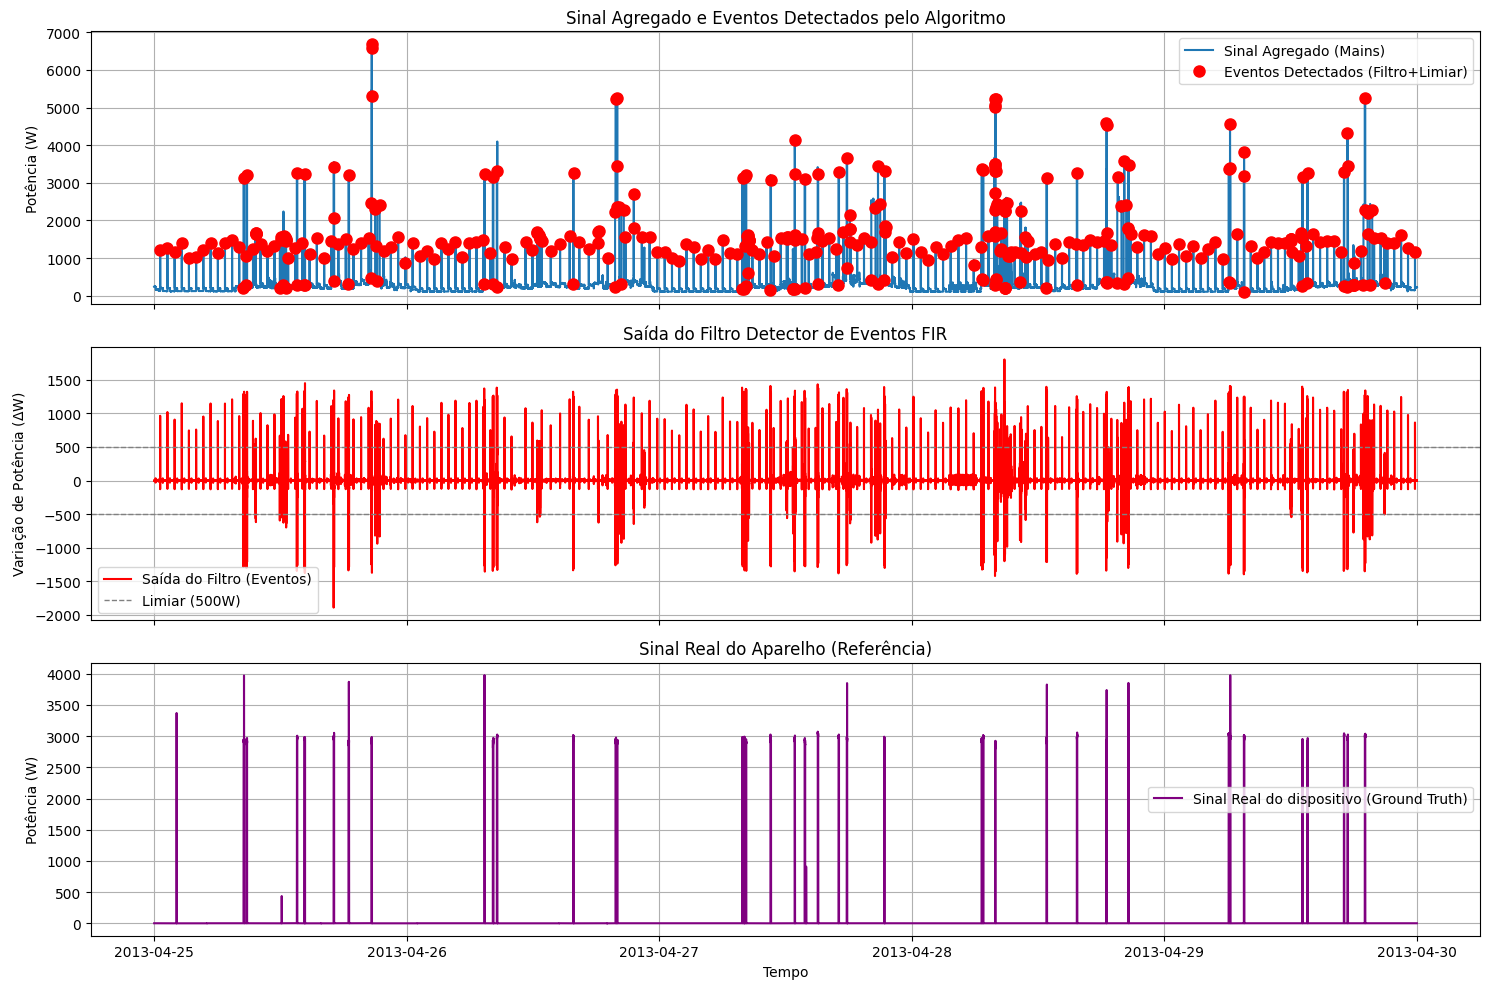

In [14]:
# --- Carregando os dados ---
# Pegar o sinal agregado e o da chaleira (ground truth)
device_power = elec['kettle'].power_series_all_data().dropna()

# --- Projeto do Filtro Passa-Alta (mesmo de antes) ---
fs = 1/6.0
numtaps = 191
cutoff_highpass = 0.005
nyq_rate = fs / 2.0
coeffs_highpass = firwin(numtaps, cutoff_highpass/nyq_rate, pass_zero=False)

# --- Aplicação do Filtro ---
event_signal = filtfilt(coeffs_highpass, 1.0, mains_power)

# Defina o limiar. Apenas variações maiores que este valor serão consideradas eventos.
# Ajuste este valor para ser mais ou menos sensível.
threshold = 500  # Em Watts

# Encontra os índices de todos os pontos que excedem o limiar
candidate_indices = np.where(np.abs(event_signal) > threshold)[0]

# Agrupa eventos próximos para evitar detecções múltiplas para um único evento.
# Se a distância entre dois pontos candidatos for menor que 5 amostras (30s), considera-se o mesmo evento.
detected_event_indices = candidate_indices[np.where(np.diff(candidate_indices, prepend=0) > 5)[0]]

# Pega os timestamps dos eventos detectados
detected_event_timestamps = mains_power.index[detected_event_indices]

print(f"Total de {len(detected_event_timestamps)} eventos detectados com limiar de {threshold}W.")

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

axes[0].plot(mains_power, label='Sinal Agregado (Mains)')
axes[0].plot(detected_event_timestamps, mains_power[detected_event_timestamps], 'o', color='red', markersize=8, label='Eventos Detectados (Filtro+Limiar)')
axes[0].set_title('Sinal Agregado e Eventos Detectados pelo Algoritmo')
axes[0].set_ylabel('Potência (W)')
axes[0].grid()
axes[0].legend()

axes[1].plot(mains_power.index, event_signal, label='Saída do Filtro (Eventos)', color='red')
axes[1].axhline(y=threshold, color='gray', linestyle='--', lw=1)
axes[1].axhline(y=-threshold, color='gray', linestyle='--', lw=1, label=f'Limiar ({threshold}W)')
axes[1].set_title('Saída do Filtro Detector de Eventos FIR')
axes[1].set_ylabel('Variação de Potência ($\Delta$W)')
axes[1].grid()
axes[1].legend()

axes[2].plot(device_power, label='Sinal Real do dispositivo (Ground Truth)', color='purple')
axes[2].set_title('Sinal Real do Aparelho (Referência)')
axes[2].set_ylabel('Potência (W)')
axes[2].set_xlabel('Tempo')
axes[2].grid()
axes[2].legend()

device_on_events = device_power[device_power > 2000]

plt.tight_layout()
plt.show()

### 4 - Caracterização de Eventos e Extração de Features

Tendo identificado os pontos de transientes, agora identificaremos a variação da potência ativa de cada evento identificado, que será realizado por meio de um filtro passa baixa

#### Características do Filtro

Como definido anteriormente, os sinais no domínio do tempo são compostos majoritarioamente por degraus e impulsos. Como estamos interessados na componente DC do sinal, devemos realizar um corte em frequências muito baixas, ceifando todas as componentes de alta frequência que compoem o degrau.

Dessa forma, a frequência de corte foi de forma semelhante do passa alta. Novamente, foi escolhido um janelamento de Hamming pelas mesmas características citadas acima, sendo que nesse caso a ordem empregada é bem menos crítica, já que o próprio filtro passa baixa já responde de boa forma ao sinal de entrada.

Por fim, é interessante observar que o filtro atenua bem os sinais agregados que geram um impulso, já que não pode ser bem definido como um evento de equipamento ligado, já que não esteve tempo suficiente em funcionamento, podendo ser até mesmo uma interferência na rede.

In [ ]:
f_cutoff = 0.02
fp = 0.01
fs = 1/6.0

M_min = 3.3/((f_cutoff-fp)/fs)
print(f"Ordem mínima: {M_min}")

Ordem mínima: 54.99999999999999


#### Aplicando filtro

Assim, aplicamos o filtro no sinal agregado e plotamos um gráfico para observar sua resposta utilizando os critérios acima e seguindo o mesmo modelo de filtragem já utilizado no passa alta.

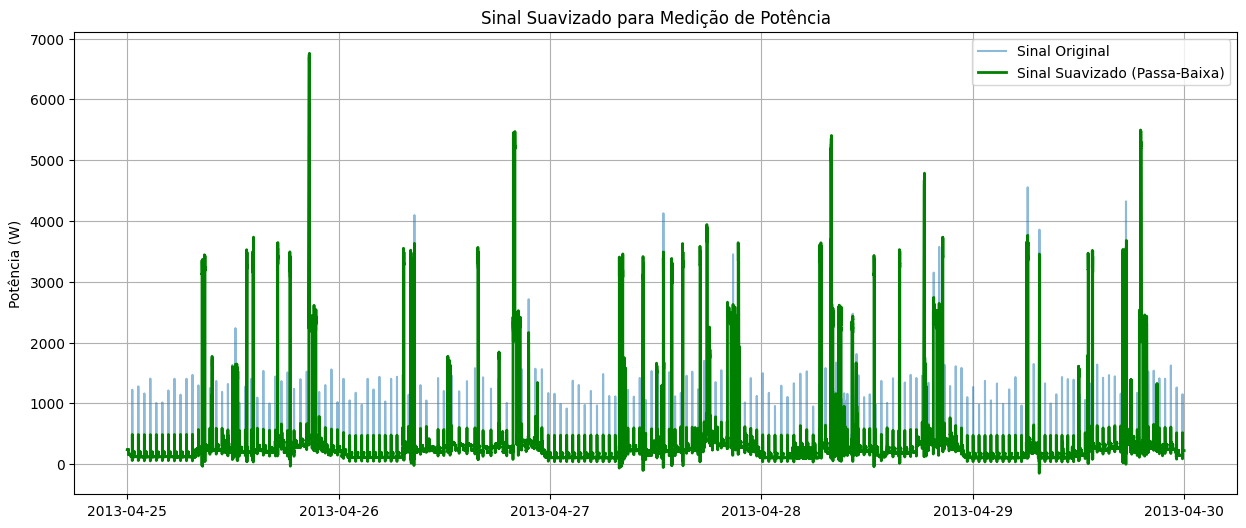

In [5]:
# --- Projeto do Filtro Passa-Baixa ---
cutoff_lowpass = 0.02
coeffs_lowpass = firwin(numtaps=61, cutoff=cutoff_lowpass/nyq_rate)

# --- Aplicação do Filtro ---
smoothed_signal = filtfilt(coeffs_lowpass, 1.0, mains_power)
# Criar um Pandas Series para facilitar o acesso por timestamp
smoothed_series = pd.Series(smoothed_signal, index=mains_power.index)

# --- Plot para Visualização ---
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mains_power, label='Sinal Original', alpha=0.5)
ax.plot(smoothed_series, label='Sinal Suavizado (Passa-Baixa)', color='green', linewidth=2)
ax.set_title('Sinal Suavizado para Medição de Potência')
ax.set_ylabel('Potência (W)')
ax.grid()
ax.legend()
plt.show()

Para compreender melhor o que foi citado anteriormente sobre o intuito do filtro passa baixa, e por que alguns picos foram muito mais amortizados que outros, dois zooms são feitos para demonstar que os eventos de impulso são amortizados e os de degrau são ressaltados.

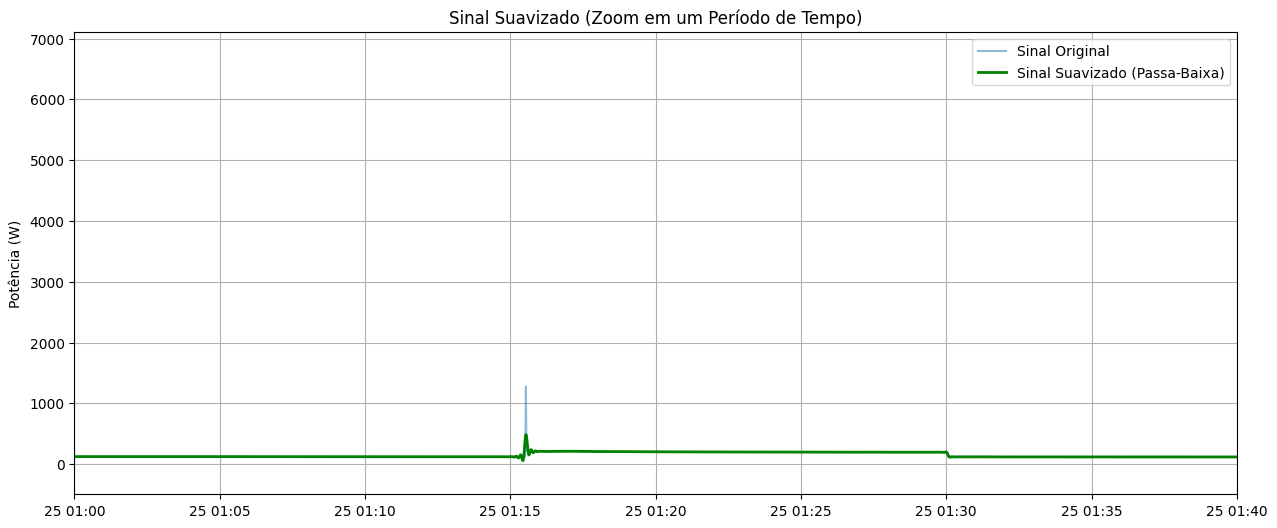

In [ ]:
# --- Plot para Visualização ---
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mains_power, label='Sinal Original', alpha=0.5)
ax.plot(smoothed_series, label='Sinal Suavizado (Passa-Baixa)', color='green', linewidth=2)

# --- ZOOM NO EIXO X ---
start_zoom = '2013-04-25 00:00:00'
end_zoom = '2013-04-25 00:40:00'
ax.set_xlim(pd.Timestamp(start_zoom), pd.Timestamp(end_zoom))

ax.set_title('Sinal Suavizado (Zoom em um Período de Tempo)')
ax.set_ylabel('Potência (W)')
ax.grid()
ax.legend()
plt.show()

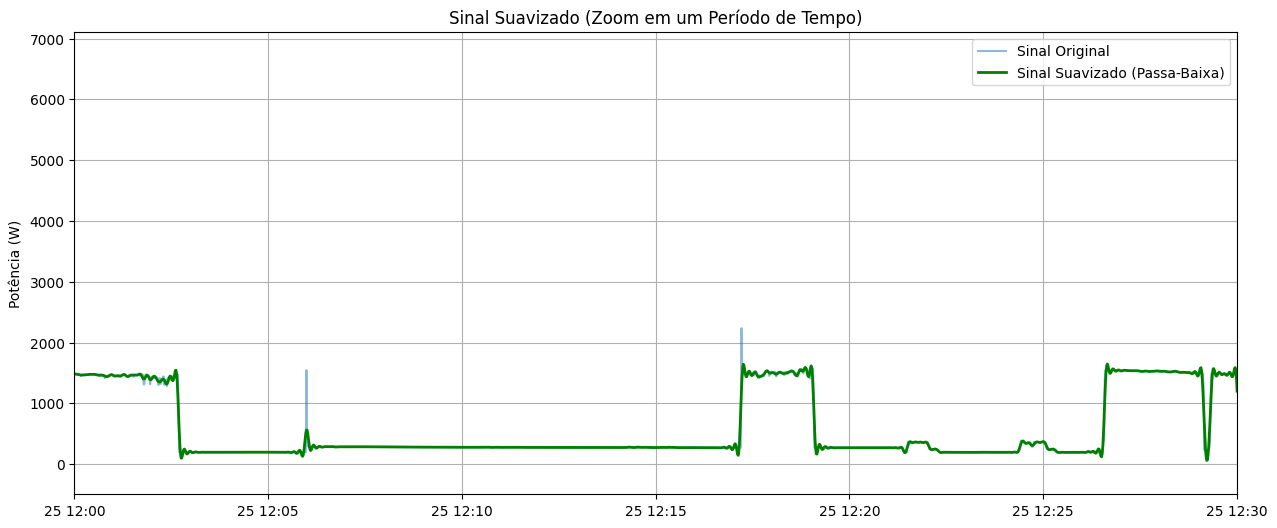

In [ ]:
# --- Plot para Visualização ---
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mains_power, label='Sinal Original', alpha=0.5)
ax.plot(smoothed_series, label='Sinal Suavizado (Passa-Baixa)', color='green', linewidth=2)

start_zoom = '2013-04-25 11:00:00'
end_zoom = '2013-04-25 11:30:00'
ax.set_xlim(pd.Timestamp(start_zoom), pd.Timestamp(end_zoom))

ax.set_title('Sinal Suavizado (Zoom em um Período de Tempo)')
ax.set_ylabel('Potência (W)')
ax.grid()
ax.legend()
plt.show()

#### Obtendo dados de variação de potência

Tendo filtrado o sinal, podemos obter a variação de potência que ocorre nos eventos capturados. Para diminuir variações maiores que deveriam, é observado um período de 1 minuto para garantir uma estabilização do sinal. Por fim esses dados são exibidos na forma do pandas.

In [7]:
event_features = []

# --- PARÂMETROS DE JANELAMENTO (JUSTIFICADOS) ---
# Intervalo de guarda para ignorar a transição do filtro. 12 segundos (2 amostras) é um bom começo.
GUARD_SECONDS = 12
# Duração da janela para medir a média do estado estável. 30 segundos é um valor robusto.
WINDOW_SECONDS = 30

# Cálculo dinâmico em número de amostras
sampling_period_seconds = (mains_power.index[1] - mains_power.index[0]).total_seconds()
guard_samples = int(GUARD_SECONDS / sampling_period_seconds)
window_samples = int(WINDOW_SECONDS / sampling_period_seconds)

n_samples = len(smoothed_series)
print(f"Analisando {len(detected_event_timestamps)} eventos candidatos...")
print(f"Usando {guard_samples} amostras de guarda e {window_samples} amostras de medição.")

for ts in detected_event_timestamps:
    loc = smoothed_series.index.get_loc(ts)

    # Janela "Antes": termina 'guard_samples' antes do evento
    start_before = loc - guard_samples - window_samples
    end_before = loc - guard_samples

    # Janela "Depois": começa 'guard_samples' depois do evento
    start_after = loc + guard_samples
    end_after = loc + guard_samples + window_samples

    # Verificação de limites para evitar erros
    if start_before < 0 or end_after >= n_samples:
        continue # Pula eventos muito próximos das bordas do sinal

    before_window = smoothed_series.iloc[start_before:end_before]
    after_window = smoothed_series.iloc[start_after:end_after]

    if before_window.isnull().any() or after_window.isnull().any() or before_window.empty or after_window.empty:
        continue

    power_before = before_window.mean()
    power_after = after_window.mean()

    delta_p = power_after - power_before
    event_features.append({'timestamp': ts, 'delta_p': delta_p})

Analisando 370 eventos candidatos...
Usando 12 amostras de guarda e 30 amostras de medição.


In [8]:
# Apresentar as features extraídas
event_features_df = pd.DataFrame(event_features)
print("\nFeatures extraídas dos eventos:")
display(event_features_df)


Features extraídas dos eventos:


,timestamp,delta_p
0,2013-04-25 00:34:17.400000095+01:00,89.281788
1,2013-04-25 01:15:32.099999905+01:00,89.032819
2,2013-04-25 01:56:35.500000+01:00,90.061106
3,2013-04-25 02:37:21+01:00,89.457596
4,2013-04-25 03:18:10.599999905+01:00,88.621840
...,...,...
365,2013-04-29 21:11:38.700000048+01:00,88.501163
366,2013-04-29 21:50:30.700000048+01:00,87.016473
367,2013-04-29 22:30:04.299999952+01:00,88.290263
368,2013-04-29 23:09:26.900000095+01:00,87.440607


### 6 - Identificação Simplificada

Após a detecção dos instantes em que os eventos ocorrem (Tarefa 3) e a caracterização da variação de potência (ΔP) para cada um deles (Tarefa 4), a etapa final da análise é a identificação simplificada. O objetivo é, com base nas features extraídas, propor regras simples para tentar classificar qual tipo de aparelho foi acionado.

Para esta tarefa, foram exploradas duas estratégias de classificação distintas: uma baseada em regras com limiares de potência fixos e outra, mais avançada, que utiliza os metadados do dataset para uma classificação dinâmica.

#### Abordagem 1: Classificação por Limiares Fixos (Hardcoded)

Esta é a abordagem mais direta para implementar um classificador baseado em regras.

##### Conceito e Metodologia

O conceito por trás deste método é o conhecimento prévio sobre o consumo de aparelhos comuns. Sabe-se que uma chaleira elétrica consome muito mais energia que uma geladeira, por exemplo. A ideia é traduzir esse conhecimento em uma série de regras `if/elif/else` diretamente no código.

O processo executado pelo código é o seguinte:
1.  Para cada evento detectado, o valor absoluto da sua variação de potência (`abs(ΔP)`) é obtido.
2.  Este valor é então comparado sequencialmente com faixas de potência pré-definidas no código. Por exemplo: `se 2500W < abs(ΔP) < 3200W, então classifique como 'kettle'`.
3.  A primeira regra que for satisfeita determina o rótulo do aparelho para aquele evento. Se nenhuma regra for satisfeita, o evento é classificado como 'unknown'.

A ordem das regras (da maior potência para a menor) foi escolhida como uma heurística simples para mitigar, parcialmente, o problema de faixas de potência que podem se sobrepor.

##### Análise da Abordagem

* **Vantagens:**
    * **Simplicidade:** É extremamente fácil de implementar e entender.
    * **Rapidez:** A lógica de verificação é computacionalmente muito leve.
* **Desvantagens:**
    * **Falta de Portabilidade:** As regras definidas para os aparelhos da Casa 1 não são diretamente aplicáveis à Casa 5, que pode ter modelos diferentes com consumos distintos.
    * **Fragilidade:** O sistema é "quebradiço". Se um morador trocar um aparelho por um modelo mais ou menos potente, a regra se torna obsoleta e o código precisa ser alterado manualmente.
    * **Ambiguidade:** Não lida bem com aparelhos cujas faixas de potência se sobrepõem. O primeiro que corresponder na cadeia `if/elif` será o vencedor, o que pode não ser o correto.

In [9]:
# --- Tarefa 6: Identificação Simplificada ---

print("--- Iniciando Tarefa 6: Identificação com Lista de Regras Estendida ---")

# --- 6.1: Definição das Novas Regras de Classificação ---
def classify_by_extended_rules(delta_p):
    """
    Aplica uma lista estendida de regras com valores de potência fixos.
    A ordem das regras (do maior para o menor consumo) é importante!
    """
    abs_delta = abs(delta_p)

    # As regras são baseadas em potências típicas de aparelhos da Casa 1 e 2.
    if 2500 < abs_delta < 3200:
        return 'kettle'
    elif 1800 < abs_delta < 2500:
        return 'washing machine'
    elif 1000 < abs_delta < 1600:
        return 'microwave'
    elif 800 < abs_delta < 1200:
        return 'toaster'
    elif 80 < abs_delta < 350:
        return 'fridge freezer'
    elif 40 < abs_delta < 150:
        return 'television'
    else:
        return 'unknown'

# --- 6.2: Aplicação das Novas Regras ---
event_features_df['classified_extended'] = event_features_df['delta_p'].apply(classify_by_extended_rules)

--- Iniciando Tarefa 6: Identificação com Lista de Regras Estendida ---


#### Abordagem 2: Classificação Dinâmica por Metadados (YAML)

Esta abordagem representa uma evolução significativa em relação ao método de limiares fixos, tornando o sistema mais inteligente e adaptável.

##### Conceito e Metodologia

O conceito aqui é parar de depender de "números mágicos" no código e, em vez disso, utilizar a rica fonte de informações que acompanha o próprio dataset: os arquivos de metadados `buildingX.yaml`. Esses arquivos descrevem as especificações de cada aparelho em cada casa.

O processo executado pelo código é mais sofisticado:
1.  **Criação do Catálogo:** Antes da classificação, o código lê o arquivo `YAML` da casa selecionada e cria um "catálogo" dinâmico de todos os aparelhos para os quais existem dados de potência (especificamente, `on_power_threshold` e `max_power`).
2.  **Busca por Correspondência:** Para cada evento e seu `ΔP`, o código não verifica uma regra fixa, mas sim percorre todo o catálogo procurando por **todos** os aparelhos cuja faixa de potência `[on_power_threshold, max_power]` seja compatível com o `ΔP` do evento.
3.  **Resolução de Ambiguidade:**
    * Se apenas um aparelho no catálogo corresponde, ele é escolhido.
    * Se **múltiplos** aparelhos corresponderem (o problema da sobreposição de faixas), uma regra de desempate é aplicada: o sistema escolhe o aparelho com a **faixa de potência mais estreita** (`max_power` - `on_power_threshold`). A justificativa é que uma definição de aparelho mais "específica" (e.g., chaleira: [2500W, 3000W]) é uma correspondência mais provável do que uma genérica (e.g., tomada: [10W, 3000W]).

##### Análise da Abordagem

* **Vantagens:**
    * **Adaptável e Portátil:** O mesmo código de classificação funciona para qualquer casa do dataset, pois ele se adapta aos aparelhos específicos de cada uma.
    * **Robusto a Mudanças:** Se os metadados de um aparelho forem atualizados no arquivo YAML, o classificador usará automaticamente as novas informações.
    * **Gerenciamento de Ambiguidade:** A regra da "melhor correspondência" (faixa mais estreita) é uma maneira inteligente e justificável de resolver conflitos, tornando a classificação mais precisa.
* **Desvantagens:**
    * **Dependência dos Metadados:** A qualidade da classificação é diretamente proporcional à qualidade e completude dos arquivos YAML. Se os metadados de um aparelho estiverem ausentes ou incorretos, o sistema não conseguirá identificá-lo.

In [10]:
# --- Tarefa 6: Identificação Simplificada (Versão com "Melhor Correspondência") ---

print("--- Iniciando Tarefa 6: Identificação com Lógica de 'Melhor Correspondência' ---")

# --- 6.1: Carregar o "Catálogo" de Aparelhos (código inalterado) ---
appliance_catalog = []
for meter in elec.all_meters():
    if not meter.is_site_meter() and meter.appliances:
        for appliance in meter.appliances:
            if 'on_power_threshold' in appliance.metadata and 'max_power' in appliance.metadata:
                appliance_info = {
                    'type': appliance.type['type'],
                    'instance': appliance.metadata.get('instance'),
                    'on_power_threshold': appliance.metadata.get('on_power_threshold'),
                    'max_power': appliance.metadata.get('max_power')
                }
                appliance_catalog.append(appliance_info)

print(f"Catálogo de {len(appliance_catalog)} aparelhos com metadados de potência carregado da Casa {building_num}.")


# --- 6.2: Definição da NOVA Função de Classificação (Mais Inteligente) ---
def classify_by_best_match(delta_p, catalog):
    """Encontra o aparelho com a faixa de potência mais estreita que corresponde ao evento."""
    abs_delta = abs(delta_p)
    possible_matches = []

    # 1. Encontra todos os aparelhos compatíveis
    for appliance in catalog:
        if appliance['on_power_threshold'] <= abs_delta <= appliance['max_power']:
            possible_matches.append(appliance)

    # 2. Decide com base no número de correspondências
    if not possible_matches:
        # Nenhum aparelho compatível encontrado
        return 'unknown'
    elif len(possible_matches) == 1:
        # Apenas uma correspondência, caso fácil
        return possible_matches[0]['type']
    else:
        # 3. Critério de Desempate: escolher a faixa mais estreita
        best_match = None
        smallest_range = float('inf')

        for appliance in possible_matches:
            power_range = appliance['max_power'] - appliance['on_power_threshold']
            if power_range < smallest_range:
                smallest_range = power_range
                best_match = appliance

        return best_match['type']

# --- 6.3: Aplicação da Nova Classificação ---
event_features_df['classified_appliance'] = event_features_df['delta_p'].apply(lambda dp: classify_by_best_match(dp, appliance_catalog))

--- Iniciando Tarefa 6: Identificação com Lógica de 'Melhor Correspondência' ---
Catálogo de 5 aparelhos com metadados de potência carregado da Casa 2.


#### Avaliação dos Resultados

Para ambas as abordagens, a etapa final consiste em comparar os rótulos gerados com os dados de "ground truth" (o consumo real de cada aparelho individual) para uma avaliação preliminar da eficácia, conforme solicitado na proposta de trabalho. Este passo é crucial para quantificar o desempenho de cada estratégia e discutir suas respectivas limitações, como o tratamento de eventos superpostos (dois aparelhos ligando ao mesmo tempo), que nenhuma dessas abordagens simplificadas consegue resolver.

Além disso, as informações textuais sobre a eficácia dos algoritmos são demonstrados para validar que mesmo com o grande número de dificuldades o sistema ainda consegue ter uma boa precissão na identificação, gerando muito mais falso negativos do que falsos positivos, o que é ótimo nesse cenário.

In [29]:
def print_results(event_features_df, elec_meters, classification_column='classified_appliance', verbose=True):
    """
    Avalia a classificação de cada evento, imprime os resultados individuais (opcional)
    e calcula as métricas de acurácia finais.

    Parâmetros:
    - event_features_df: DataFrame com os eventos e suas classificações.
    - elec_meters: O objeto MeterGroup da casa para acesso ao ground truth.
    - classification_column: O nome da coluna no DataFrame que contém os rótulos classificados.
    - verbose: Se True, imprime a avaliação de cada evento individualmente.
    """
    # --- 1. Inicialização dos Contadores ---
    total_detected_events = len(event_features_df)
    correct_classifications = 0
    evaluable_events = 0 # Eventos que foram classificados e cujo ground truth foi encontrado

    if verbose:
        print(f"\n--- Avaliação Detalhada (Coluna: '{classification_column}') ---")

    # --- 2. Loop de Avaliação e Contagem ---
    for index, event in event_features_df.iterrows():
        ts = event['timestamp']
        delta_p = event['delta_p']
        classified = event[classification_column]

        if classified != 'unknown':
            try:
                meter_or_group = elec_meters[classified]
                ground_truth_series = meter_or_group.power_series_all_data()

                if ground_truth_series is None or ground_truth_series.empty:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Ground Truth INDISPONÍVEL.")
                    continue

                position_array = ground_truth_series.index.get_indexer([ts], method='nearest', tolerance=pd.Timedelta('3s'))

                if position_array[0] == -1:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Nenhum ponto no Ground Truth encontrado na vizinhança.")
                    continue
                
                evaluable_events += 1
                
                nearest_index_pos = position_array[0]
                local_window = ground_truth_series.iloc[max(0, nearest_index_pos - 2) : nearest_index_pos + 3]
                
                if local_window.empty:
                    if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: Janela de busca no Ground Truth vazia.")
                    continue
                
                ground_truth_power = local_window.max() if delta_p > 0 else local_window.min()
                is_on_truth = ground_truth_power > 20
                
                is_correct = (delta_p > 0 and is_on_truth) or (delta_p < 0 and not is_on_truth)
                
                if is_correct:
                    correct_classifications += 1
                
                if verbose:
                    evaluation = "CORRETA" if is_correct else "INCORRETA"
                    print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Classificado como '{classified}'. Verificação: {evaluation} (Real: {ground_truth_power:.0f}W)")

            except Exception as e:
                if verbose: print(f"Evento em {ts.time()} (ΔP = {delta_p:+.0f}W): Ocorreu um erro inesperado na avaliação: {e}")
    
    # --- 3. Cálculo e Apresentação das Métricas Finais ---
    accuracy_evaluable = (correct_classifications / evaluable_events * 100) if evaluable_events > 0 else 0
    accuracy_overall = (correct_classifications / total_detected_events * 100) if total_detected_events > 0 else 0

    print("\n" + "="*40)
    print("--- Resumo da Eficácia do Algoritmo ---")
    print(f"Coluna Avaliada: '{classification_column}'")
    print("-" * 40)
    print(f"Total de Eventos Detectados: {total_detected_events}")
    print(f"Eventos Classificados e Verificáveis: {evaluable_events}")
    print(f"Classificações Corretas: {correct_classifications}")
    print("-" * 40)
    print(f"Acurácia (sobre eventos verificáveis): {accuracy_evaluable:.2f}%")
    print(f"Acurácia Geral (sobre todos os eventos): {accuracy_overall:.2f}%")
    print("="*40)

In [30]:
# --- 6.2: Aplicação das Novas Regras ---
event_features_df['classified_extended'] = event_features_df['delta_p'].apply(classify_by_extended_rules)

# --- 6.3: Avaliação Preliminar com o Ground Truth ---
print("\n--- Avaliação Preliminar da Classificação com Regras Estendidas ---")
print_results(event_features_df, elec)


--- Avaliação Preliminar da Classificação com Regras Estendidas ---

--- Avaliação Detalhada (Coluna: 'classified_appliance') ---
Evento em 00:34:17.400000 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 01:15:32.099999 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 01:56:35.500000 (ΔP = +90W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 02:37:21 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 03:18:10.599999 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 03:59:17.900000 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 04:40:19.500000 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h5 file is not open!
Evento em 05:21:37.099999 (ΔP = +89W): Ocorreu um erro inesperado na avaliação: ../uk-dale.h

In [22]:
print("\n--- Tabela Final de Eventos Classificados ---")
display(event_features_df)


--- Tabela Final de Eventos Classificados ---


,timestamp,delta_p,classified_extended,classified_appliance
0,2013-04-25 00:34:17.400000095+01:00,89.281788,fridge freezer,fridge
1,2013-04-25 01:15:32.099999905+01:00,89.032819,fridge freezer,fridge
2,2013-04-25 01:56:35.500000+01:00,90.061106,fridge freezer,fridge
3,2013-04-25 02:37:21+01:00,89.457596,fridge freezer,fridge
4,2013-04-25 03:18:10.599999905+01:00,88.621840,fridge freezer,fridge
...,...,...,...,...
365,2013-04-29 21:11:38.700000048+01:00,88.501163,fridge freezer,fridge
366,2013-04-29 21:50:30.700000048+01:00,87.016473,fridge freezer,fridge
367,2013-04-29 22:30:04.299999952+01:00,88.290263,fridge freezer,fridge
368,2013-04-29 23:09:26.900000095+01:00,87.440607,fridge freezer,fridge


In [23]:
# --- 6.3: Aplicação da Nova Classificação ---
event_features_df['classified_appliance'] = event_features_df['delta_p'].apply(lambda dp: classify_by_best_match(dp, appliance_catalog))

# --- 6.4: Avaliação Preliminar com o Ground Truth ---
print("\n--- Avaliação Preliminar da Classificação (com Busca Inteligente no Ground Truth) ---")

print_results(event_features_df, elec)


--- Avaliação Preliminar da Classificação (com Busca Inteligente no Ground Truth) ---

--- Avaliação Detalhada (Coluna: 'classified_appliance') ---
Evento em 00:34:17.400000 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 01:15:32.099999 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 01:56:35.500000 (ΔP = +90W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 02:37:21 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 03:18:10.599999 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 03:59:17.900000 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 04:40:19.500000 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Evento em 05:21:37.099999 (ΔP = +89W): Classificado como 'fridge'. Verificação: Ground Truth INDISPONÍVEL.
Ev

In [15]:
print("\n--- Tabela Final de Eventos Classificados ---")
display(event_features_df)


--- Tabela Final de Eventos Classificados ---


,timestamp,delta_p,classified_extended,classified_appliance
0,2013-04-25 00:34:17.400000095+01:00,89.281788,fridge freezer,fridge
1,2013-04-25 01:15:32.099999905+01:00,89.032819,fridge freezer,fridge
2,2013-04-25 01:56:35.500000+01:00,90.061106,fridge freezer,fridge
3,2013-04-25 02:37:21+01:00,89.457596,fridge freezer,fridge
4,2013-04-25 03:18:10.599999905+01:00,88.621840,fridge freezer,fridge
...,...,...,...,...
365,2013-04-29 21:11:38.700000048+01:00,88.501163,fridge freezer,fridge
366,2013-04-29 21:50:30.700000048+01:00,87.016473,fridge freezer,fridge
367,2013-04-29 22:30:04.299999952+01:00,88.290263,fridge freezer,fridge
368,2013-04-29 23:09:26.900000095+01:00,87.440607,fridge freezer,fridge


In [24]:
if dataset:
        dataset.store.close()

### Extra: Caso de erro do filtro

Por mais que o dataset esteja conciso, de forma que as informações acima apresentadas funcionam para as casas 1,2 4 e 5, na casa 3 foi observado que o consumo agregado não apresenta uma característica constante, fazendo com que o filtro capte transições excessivas e não consiga identificar corretamente o acionamento do dispositivo. Abaixo está amostrado uma análise para demonstrar tal fenômeno.

Carregando o dataset HDF5...
Dados da Casa 3 carregados com sucesso.
Período selecionado: de 2013-02-27 20:35:14+00:00 a 2013-03-09 23:59:56+00:00
Medidor principal ('site_meter') encontrado manualmente: ElecMeter(instance=1, building=3, dataset='UK-DALE', site_meter, appliances=[])
Plotando os dados do medidor principal...


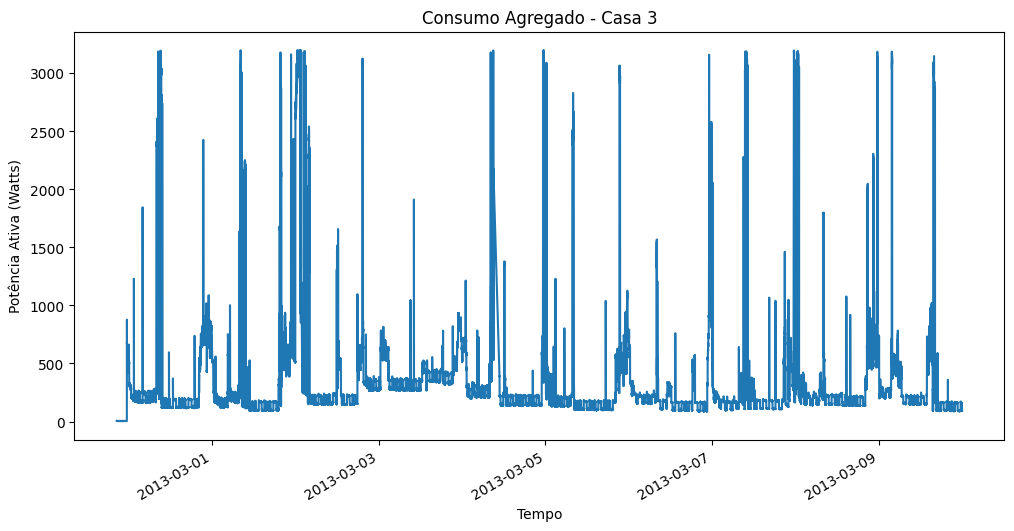

Total de 218 eventos detectados com limiar de 500W.


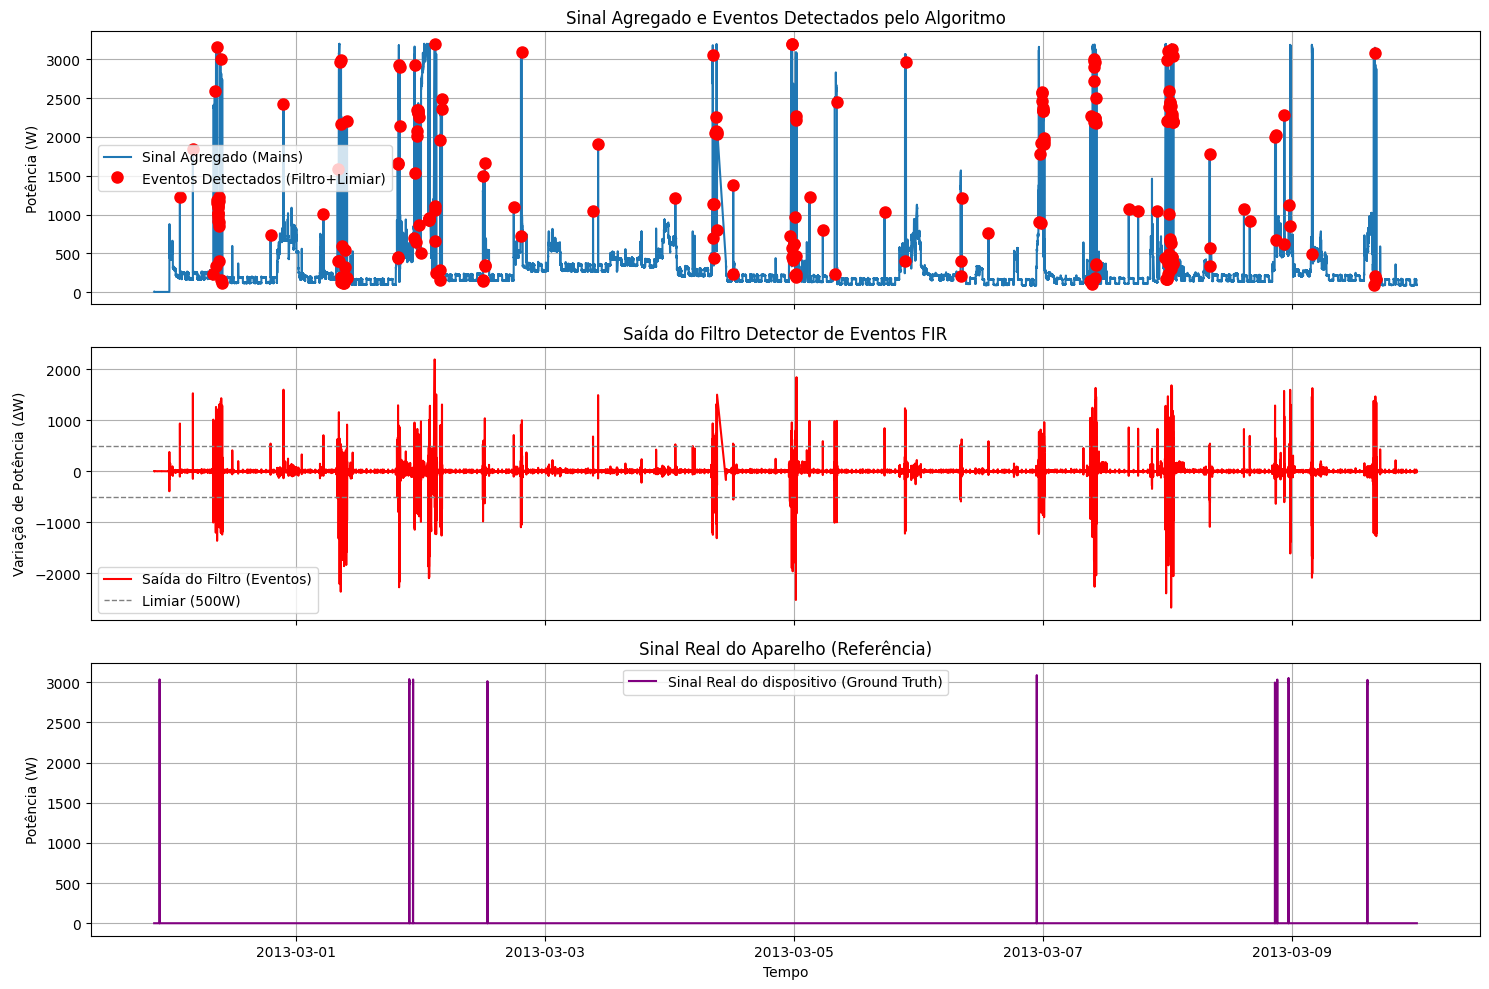

In [31]:
# --- Imports e Configurações Iniciais ---
# Configurações do matplotlib para os gráficos
plt.rcParams['figure.figsize'] = [15, 8]

# --- Carregamento do Dataset ---
print("Carregando o dataset HDF5...")
dataset = DataSet('uk-dale.h5')

# Escolha a casa e o período para análise
building_num = 3

dataset.set_window(start="2013-02-27", end="2013-03-10") # Tempo para casa 3

elec = dataset.buildings[building_num].elec
mains_power = elec.mains().power_series_all_data().dropna()

print(f"Dados da Casa {building_num} carregados com sucesso.")
print(f"Período selecionado: de {mains_power.index[0]} a {mains_power.index[-1]}")

mains_meter = None
for meter in elec.meters:
    if meter.is_site_meter():
        print(f"Medidor principal ('site_meter') encontrado manualmente: {meter}")
        mains_meter = meter
        break

if mains_meter:
    print("Plotando os dados do medidor principal...")
    aggregated_data = mains_meter.power_series_all_data()

    if aggregated_data is not None and not aggregated_data.empty:
        aggregated_data.plot(figsize=(12, 6))
        plt.title(f'Consumo Agregado - Casa {building_num}')
        plt.ylabel('Potência Ativa (Watts)')
        plt.xlabel('Tempo')
        plt.show()
    else:
        print(f"Os dados para o medidor principal da Casa {building_num} estão vazios ou não puderam ser carregados.")
else:
    print(f"ERRO CRÍTICO: Não foi possível encontrar o medidor principal para a Casa {building_num}.")

# --- Carregando os dados ---
# Pegar o sinal agregado e o da chaleira (ground truth)
device_power = elec['kettle'].power_series_all_data().dropna()

# --- Projeto do Filtro Passa-Alta (mesmo de antes) ---
fs = 1/6.0
numtaps = 191
cutoff_highpass = 0.005
nyq_rate = fs / 2.0
coeffs_highpass = firwin(numtaps, cutoff_highpass/nyq_rate, pass_zero=False)

# --- Aplicação do Filtro ---
event_signal = filtfilt(coeffs_highpass, 1.0, mains_power)

# Defina o limiar. Apenas variações maiores que este valor serão consideradas eventos.
# Ajuste este valor para ser mais ou menos sensível.
threshold = 500  # Em Watts

# Encontra os índices de todos os pontos que excedem o limiar
candidate_indices = np.where(np.abs(event_signal) > threshold)[0]

# Agrupa eventos próximos para evitar detecções múltiplas para um único evento.
# Se a distância entre dois pontos candidatos for menor que 5 amostras (30s), considera-se o mesmo evento.
detected_event_indices = candidate_indices[np.where(np.diff(candidate_indices, prepend=0) > 5)[0]]

# Pega os timestamps dos eventos detectados
detected_event_timestamps = mains_power.index[detected_event_indices]

print(f"Total de {len(detected_event_timestamps)} eventos detectados com limiar de {threshold}W.")

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

axes[0].plot(mains_power, label='Sinal Agregado (Mains)')
axes[0].plot(detected_event_timestamps, mains_power[detected_event_timestamps], 'o', color='red', markersize=8, label='Eventos Detectados (Filtro+Limiar)')
axes[0].set_title('Sinal Agregado e Eventos Detectados pelo Algoritmo')
axes[0].set_ylabel('Potência (W)')
axes[0].grid()
axes[0].legend()

axes[1].plot(mains_power.index, event_signal, label='Saída do Filtro (Eventos)', color='red')
axes[1].axhline(y=threshold, color='gray', linestyle='--', lw=1)
axes[1].axhline(y=-threshold, color='gray', linestyle='--', lw=1, label=f'Limiar ({threshold}W)')
axes[1].set_title('Saída do Filtro Detector de Eventos FIR')
axes[1].set_ylabel('Variação de Potência ($\Delta$W)')
axes[1].grid()
axes[1].legend()

axes[2].plot(device_power, label='Sinal Real do dispositivo (Ground Truth)', color='purple')
axes[2].set_title('Sinal Real do Aparelho (Referência)')
axes[2].set_ylabel('Potência (W)')
axes[2].set_xlabel('Tempo')
axes[2].grid()
axes[2].legend()

device_on_events = device_power[device_power > 2000]

plt.tight_layout()
plt.show()